## $\mathbf{E}\times \mathbf{B}$ Drift

In [33]:
import em2d
import numpy
import numpy as np
# Time step
dt = 0.01

# Simulation time
tmax = 22.8

# Number of cells
nx  = [128,32]

# Simulation box size
box = [12,3]


## Background plasma

# Particles per cell
ppc = [1,1]

dens=em2d.Density( type = "slab", start = 6.4,end=6.6)
dens.n=1e-6
# Use a step density profile
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[0.1,0,0])

dens2=em2d.Density( type = "slab", start = 6.4,end=6.6)
dens2.n=1e-6
positrons = em2d.Species( "positrons", 1, ppc,
                           density = dens2,ufl=[0.1,0,0])

# Initialize simulation
sim = em2d.Simulation( nx, box, dt, species = (electrons,positrons) )

# Set moving window
#sim.set_moving_window()

# Set current smoothing
#sim.set_smooth( em2d.Smooth(xtype = "compensated", xlevel = 4) )


#sim.emf.bc_type="open"


def ext_B(x,y):
    return [0,0,1]

def ext_E(x,y):
    return [0,0.01,0]

ex=em2d.Ext_Field(sim,ext_E=ext_E,ext_B=ext_B)

#arays to store the particles trajectories
pos_part_rep =[]
ele_part_rep =[]

def itera():
    sim.current.zero()
    species=sim.get_species()
    for spec in species:
        spec.advance(sim)

    sim.current.update()
    sim.emf.advance(sim)
    ex.update_ext(sim)
    sim.advance()
    print(sim.emf.E_part[:,:,1])
    
    #store the electron trajectories
    ele_part_rep.append(sim.get_species()[0].particles[30].copy())
    #store the positron(ish) trajectories
    pos_part_rep.append(sim.get_species()[1].particles[28].copy())


while sim.t < 2*1.5*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    itera()

[[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]
[[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]
[[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]
[[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]
[[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01000001 0.01000001 0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01000001 0.01000001 0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000002 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000002 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01000001 0.01000001]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01000001 0.01000001]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01000002 0.01000002 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01000002 0.01000002 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01000001 ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01000001 0.01000001 0.01000001 ... 

[[0.01       0.01       0.01       ... 0.01       0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01      ]
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01      ]
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 

[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000001]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.00999999 ... 0.01000001 0.01000001 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000001]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.00999999 ... 0.01000001 0.01000001 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 

[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999998 0.00999998]
 [0.00999998 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]
 ...
 [0.01       0.01       0.01000001 ... 0.01       0.01       0.01      ]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999998 0.00999998]
 [0.00999998 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]
 ...
 [0.01       0.01       0.01000001 ... 0.01       0.01       0.01      ]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 

[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000002 0.01000002]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000002 0.01000002]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 

[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000002 0.01000002]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000002 0.01000002]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 

[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000002]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999998 0.00999998 0.00999998 ... 0.01       0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000002]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999998 0.00999998 0.00999998 ... 0.01       0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 

[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01       0.01       0.01      ]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01       0.01       0.01      ]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 

[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000001 0.01000001 ... 0.00999998 0.00999999 0.00999999]
 [0.00999999 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01000001 0.01000001 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000001 0.01000001 ... 0.00999998 0.00999999 0.00999999]
 [0.00999999 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01000001 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000001 0.01000001 ... 

[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 

[[0.01000001 0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01       0.01000001 0.01000001]
 ...
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999999 ... 0.00999999 0.00999999 0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01       0.01      ]]
[[0.01000001 0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01       0.01000001 0.01000001]
 ...
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999999 ... 0.00999999 0.00999999 0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01       0.01      ]]
[[0.01000001 0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 

[[0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01       0.01       0.01      ]
 ...
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999999 0.00999999 0.00999999 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.01       0.01       ... 0.01000001 0.01000001 0.01000001]]
[[0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01       ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01       0.01       0.01      ]
 ...
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999999 0.00999999 0.00999999 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.01       ... 0.01000001 0.01000001 0.01000001]]
[[0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01       ... 

[[0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01       0.01       0.01       ... 0.00999999 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01000002 0.01000001 0.01000001 ... 0.00999998 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]]
[[0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01       0.01       0.01       ... 0.00999999 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01000002 0.01000001 0.01000001 ... 0.00999998 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]]
[[0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01       0.01       0.01       ... 

[[0.01000002 0.01000001 0.01000001 ... 0.01000001 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000001 0.01000001]]
[[0.01000002 0.01000001 0.01000001 ... 0.01000001 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000001 0.01000001]]
[[0.01000002 0.01000001 0.01000001 ... 0.01000001 0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.00999999 0.00999999 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.00999999 0.00999999 0.01      ]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.00999998 0.00999998 0.00999998]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.00999999 0.00999999 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.00999999 0.00999999 0.01      ]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.00999998 0.00999998 0.00999998]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.00999999 0.00999999 ... 

[[0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01       0.01       0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 ...
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.01       0.01       0.01       ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01       0.01       0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 ...
 [0.01000001 0.01000001 0.01       ... 0.00999999 0.00999999 0.00999999]
 [0.01       0.01       0.01       ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.01       0.01       0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 

[[0.01000002 0.01000002 0.01000003 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 ...
 [0.01       0.01       0.01       ... 0.00999999 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000002 0.01000003]]
[[0.01000002 0.01000002 0.01000003 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 ...
 [0.01       0.01       0.01       ... 0.00999999 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000002 0.01000003]]
[[0.01000002 0.01000002 0.01000003 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 

[[0.01000002 0.01000003 0.01000003 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000003 0.01000003]]
[[0.01000002 0.01000003 0.01000003 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999998 0.00999999 0.00999999]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000003 0.01000003]]
[[0.01000002 0.01000003 0.01000003 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999998 0.00999998 ... 

[[0.01000002 0.01000003 0.01000003 ... 0.00999999 0.00999999 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.01       0.01       0.00999999 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01000001 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000003 0.01000003]]
[[0.01000002 0.01000003 0.01000003 ... 0.00999999 0.00999999 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.01       0.00999999 0.00999999 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01000001 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000003 0.01000003]]
[[0.01000002 0.01000003 0.01000003 ... 0.00999999 0.00999999 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 

[[0.01000002 0.01000003 0.01000003 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.00999999 0.00999999 0.00999999 ... 0.01       0.01       0.01      ]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000003 0.01000003]]
[[0.01000002 0.01000003 0.01000003 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.00999999 0.00999999 0.00999999 ... 0.01       0.01       0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000003 0.01000003]]
[[0.01000002 0.01000003 0.01000003 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 

[[0.01000002 0.01000003 0.01000003 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000001 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999998 0.00999998 ... 0.01000002 0.01000003 0.01000003]]
[[0.01000002 0.01000003 0.01000003 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000001 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999998 ... 0.01000002 0.01000003 0.01000003]]
[[0.01000002 0.01000003 0.01000003 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 

[[0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999998 ... 

[[0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999999 ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999998 0.00999999 ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 ...
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.00999998 0.00999998 0.00999998]
 [0.00999998 0.00999999 0.00999999 ... 

[[0.01000002 0.01000002 0.01000002 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999998]
 ...
 [0.01       0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000002 0.01000002]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999998]
 ...
 [0.01       0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000002 0.01000002 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.00999999 ... 0.01000002 0.01000002 0.01000002]]
[[0.01000002 0.01000002 0.01000002 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 

[[0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]]
[[0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 0.01000002 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 ...
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01000001 0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]]
[[0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 [0.00999999 0.00999999 0.00999999 ... 

[[0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.00999999 0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.00999999 0.00999999 0.00999999]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01       0.01       ... 0.01000001 0.01000001 0.01000001]]
[[0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.00999999 0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.00999999 0.00999999]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01       0.01       ... 0.01000001 0.01000001 0.01000001]]
[[0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000002 0.01000002 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 

[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01000001]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01       0.01       0.01000001 ... 0.01000002 0.01000002 0.01000002]
 [0.01000002 0.01000001 0.01000001 ... 0.01000002 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01000001 0.01000001 0.01      ]
 [0.01       0.01       0.01       ... 0.01000001 0.01000001 0.01000001]
 ...
 [0.01       0.01       0.01000001 ... 0.01000002 0.01000002 0.01000002]
 [0.01000001 0.01000001 0.01000001 ... 0.01000002 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 0.01       0.01       0.01      ]]
[[0.01       0.01       0.00999999 ... 0.01000001 0.01000001 0.01000001]
 [0.01000001 0.01000001 0.01000001 ... 

In [19]:
itera()

[[1.00000001e-07 1.00000001e-07 1.00000001e-07 ... 1.00000001e-07
  1.00000001e-07 1.00000001e-07]
 [1.00000001e-07 1.00000001e-07 1.00000001e-07 ... 1.00000001e-07
  1.00000108e-07 1.00028345e-07]
 [1.00059175e-07 1.00031059e-07 1.00000115e-07 ... 1.00000001e-07
  1.00000001e-07 1.00000001e-07]
 ...
 [1.00000001e-07 1.00000001e-07 1.00000001e-07 ... 1.00000001e-07
  1.00000001e-07 1.00000001e-07]
 [1.00000001e-07 1.00000001e-07 1.00000001e-07 ... 1.00000001e-07
  1.00000001e-07 1.00000001e-07]
 [1.00000001e-07 1.00000001e-07 1.00000001e-07 ... 1.00000001e-07
  1.00000001e-07 1.00000001e-07]]


In [20]:

print(sim.emf.E_part[-1,:,1])


[1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07]


In [34]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

In [28]:
ele_part_rep

[(68, 15, 0.51061374, 0.5, 0.1, -7.966666e-23, 1.6042832e-10),
 (68, 15, 0.52122694, 0.50010455, 0.0999951, 0.00098501, 1.6042832e-10),
 (68, 15, 0.5318386, 0.50031364, 0.0999804, 0.00196993, 1.6042832e-10),
 (68, 15, 0.5424476, 0.5006272, 0.0999559, 0.00295465, 1.6042832e-10),
 (68, 15, 0.553053, 0.5010453, 0.09992161, 0.00393908, 1.6042832e-10),
 (68, 15, 0.56365377, 0.50156784, 0.09987751, 0.00492311, 1.6042832e-10),
 (68, 15, 0.5742488, 0.50219476, 0.09982363, 0.00590666, 1.6042832e-10),
 (68, 15, 0.584837, 0.502926, 0.09975997, 0.00688963, 1.6042832e-10),
 (68, 15, 0.5954175, 0.5037615, 0.09968653, 0.00787191, 1.6042832e-10),
 (68, 15, 0.60598916, 0.50470114, 0.09960332, 0.00885342, 1.6042832e-10),
 (68, 15, 0.6165509, 0.5057449, 0.09951034, 0.00983404, 1.6042832e-10),
 (68, 15, 0.6271018, 0.5068926, 0.09940761, 0.0108137, 1.6042832e-10),
 (68, 15, 0.6376407, 0.5081442, 0.09929515, 0.01179228, 1.6042832e-10),
 (68, 15, 0.64816666, 0.50949955, 0.09917295, 0.0127697, 1.6042832e-10),

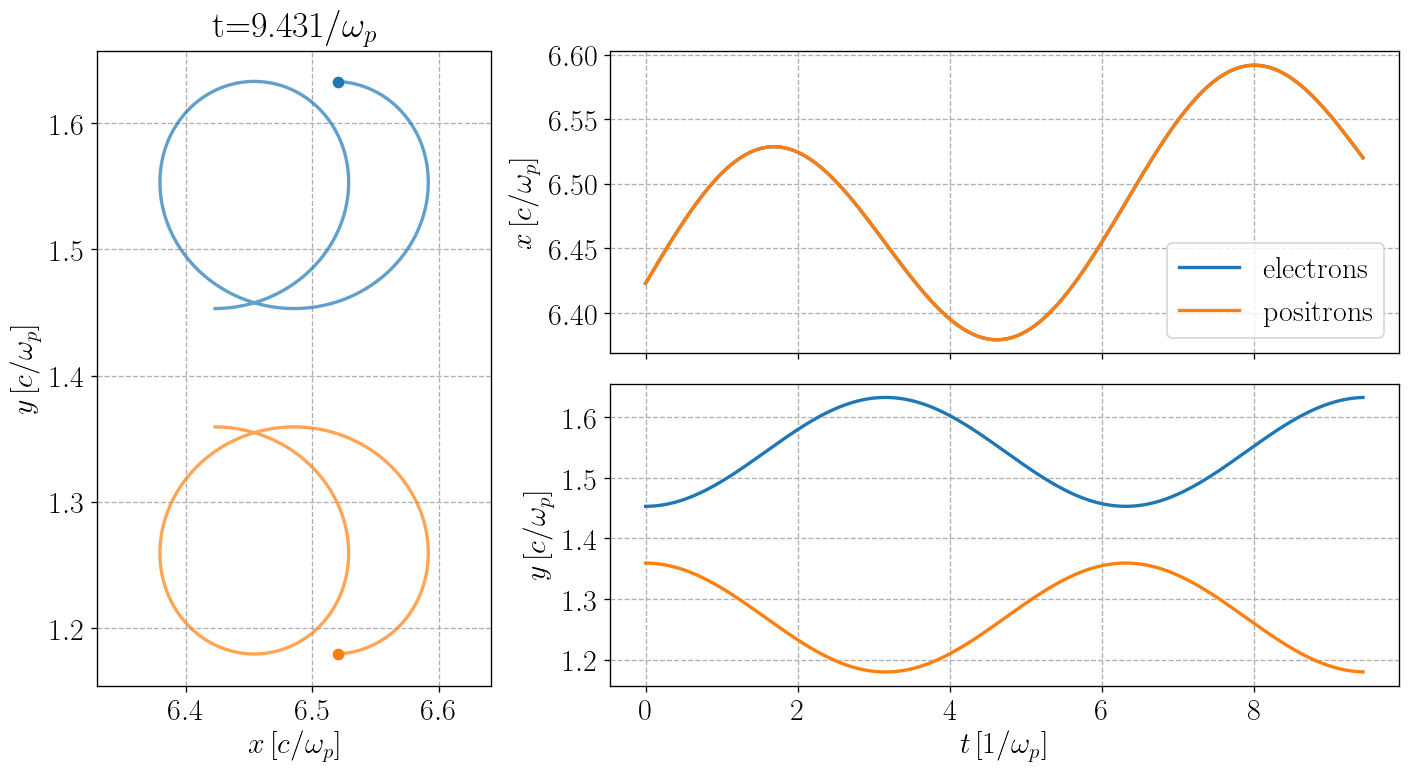

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
mpl.rc('text', usetex = 'True')
mpl.rc('font', family = 'serif')

gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

ax = plt.subplot(gs2[:, 0])
ax.plot(e_posx_t,e_posy_t,lw=2,alpha=0.7)
ax.scatter(e_posx_t[-1],e_posy_t[-1])
ax.plot(p_posx_t,p_posy_t,lw=2,alpha=0.7)
ax.scatter(p_posx_t[-1],p_posy_t[-1])
ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}$1/\omega_p$".format(sim.t))

ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,e_posx_t,lw=2,label="electrons")
ax2.plot(t,p_posx_t,lw=2,label="positrons")
ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")
ax2.legend()

ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)
ax3.plot(t,p_posy_t,lw=2)
ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")
plt.show()

In [161]:
while sim.t < 2*1.75*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    itera()

In [163]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

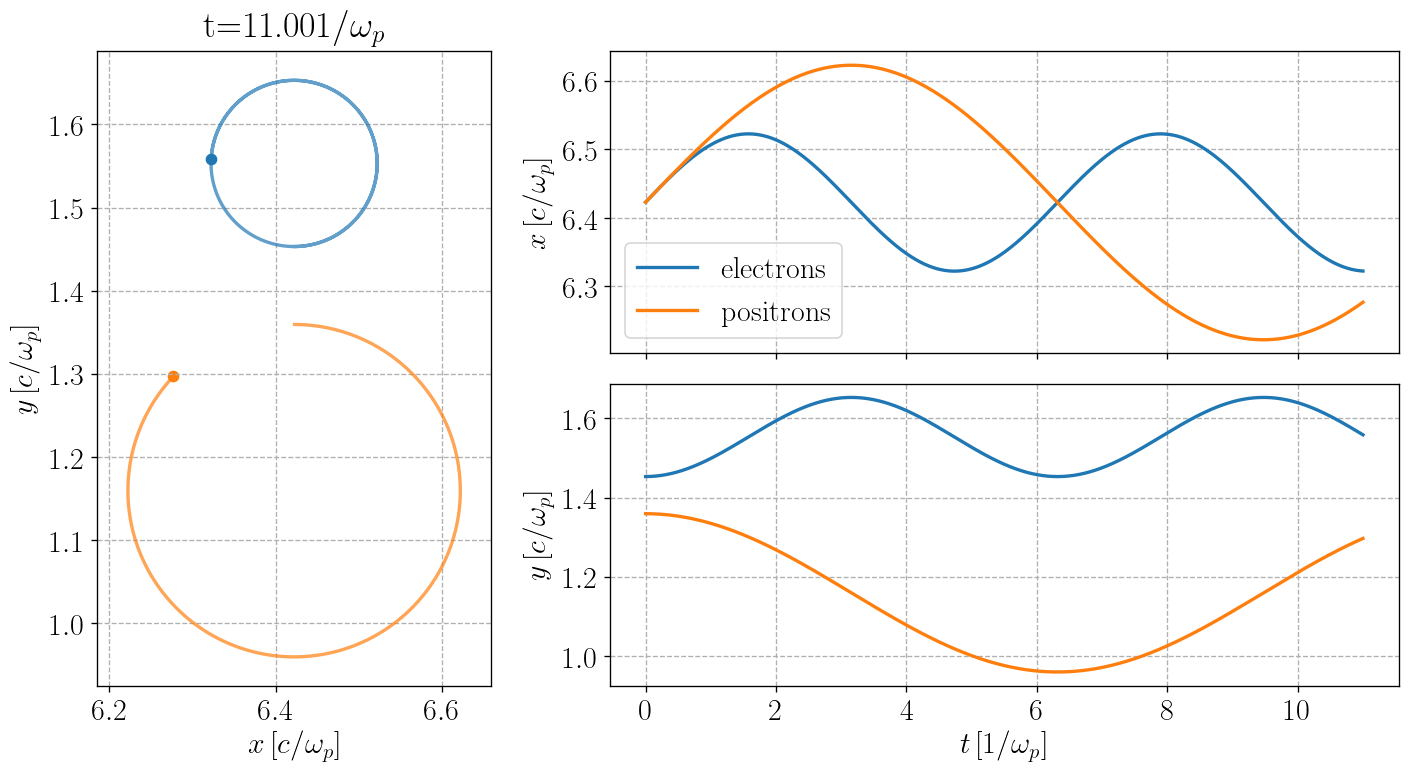

In [166]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
mpl.rc('text', usetex = 'True')
mpl.rc('font', family = 'serif')

gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

ax = plt.subplot(gs2[:, 0])
ax.plot(e_posx_t,e_posy_t,lw=2,alpha=0.7)
ax.scatter(e_posx_t[-1],e_posy_t[-1])
ax.plot(p_posx_t,p_posy_t,lw=2,alpha=0.7)
ax.scatter(p_posx_t[-1],p_posy_t[-1])
ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}$1/\omega_p$".format(sim.t))

ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,e_posx_t,lw=2,label="electrons")
ax2.plot(t,p_posx_t,lw=2,label="positrons")
ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")
ax2.legend()

ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)
ax3.plot(t,p_posy_t,lw=2)
ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")
plt.show()